# Assignment 1 — Logistic Regression (NumPy)  

**Mục tiêu bài này**:  
- Tự cài Logistic Regression **thuần NumPy** (không dùng sklearn cho mô hình).  
- Huấn luyện bằng **Gradient Descent**.  
- Gộp nhãn 3 lớp → 2 lớp: **Graduate = 1**, **Dropout/Enrolled = 0**.  
- Đánh giá mô hình (train/test).  
- Vẽ **loss** trong quá trình train.  
- Thêm **ma trận tương quan** để nhìn nhanh mối quan hệ giữa các biến.


In [1]:
# Import cơ bản cho xử lý dữ liệu và vẽ hình (không dùng thư viện ML để train)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Đặt seed để kết quả có thể lặp lại
rng = np.random.default_rng(42)

def safe_show():
    """Một hàm nhỏ để gọi plt.show() an toàn (phòng trường hợp môi trường không hỗ trợ display)."""
    try:
        plt.show()
    except Exception as e:
        print("Plot display error:", e)


## 1) Chuẩn bị dữ liệu  

Ở đây mình ưu tiên tải dữ liệu bằng `ucimlrepo` (id=697). Nếu môi trường offline thì có thể thay bằng cách nạp CSV thủ công.  
Sau khi có dữ liệu, mình sẽ gộp nhãn về 2 lớp cho phù hợp với Logistic Regression nhị phân.


In [2]:
# Tải dữ liệu từ UCI qua ucimlrepo
X, y = None, None
try:
    from ucimlrepo import fetch_ucirepo
    ds = fetch_ucirepo(id=697)
    X = ds.data.features.copy()
    y = ds.data.targets.copy()
    print("Loaded via ucimlrepo.")
    print("X shape:", X.shape, "| y shape:", y.shape)
    print("y head:\n", y.head())
except Exception as e:
    print("⚠️ Không thể tải bằng ucimlrepo (offline hoặc lỗi kết nối).")
    print("Chi tiết:", e)
    print("→ Có thể thay bằng cách nạp CSV thủ công (không triển khai ở đây).")

assert X is not None and y is not None, "Dataset chưa sẵn sàng. Vui lòng chạy ở môi trường có mạng hoặc nạp CSV."


Loaded via ucimlrepo.
X shape: (4424, 36) | y shape: (4424, 1)
y head:
      Target
0   Dropout
1  Graduate
2   Dropout
3  Graduate
4  Graduate


## 2) Tiền xử lý & gộp nhãn (3 → 2)  

- Biến `Target` được gộp như sau: **Graduate → 1**, **Dropout/Enrolled → 0**.  
- One-hot các cột phân loại.  
- Chuẩn hóa theo **train**.  
- Thêm cột **bias** (1) để mô hình học intercept.


In [3]:
# Xác định cột nhãn
target_col = 'Target' if 'Target' in y.columns else y.columns[0]
y_str = y[target_col].astype(str)

# Gộp nhãn: Graduate = 1; phần còn lại (Dropout/Enrolled) = 0
y_bin = y_str.map(lambda t: 1 if t.lower().startswith('gradu') else 0).values.astype(int)

# In thử phân bố nhãn sau khi gộp
uniq, cnt = np.unique(y_bin, return_counts=True)
print("Label distribution (after binarization):", dict(zip(uniq, cnt)))

# One-hot cho các cột không phải số
df_all = X.copy()
cat_cols = df_all.select_dtypes(exclude=[np.number]).columns.tolist()
df_all = pd.get_dummies(df_all, columns=cat_cols, drop_first=True)

# Chuyển sang NumPy
X_all = df_all.fillna(0).values.astype(float)

# Chia train/test theo tỉ lệ 80/20
n = X_all.shape[0]
idx = np.arange(n)
rng.shuffle(idx)
split = int(0.8 * n)
tr_idx, te_idx = idx[:split], idx[split:]

Xtr_raw, Xte_raw = X_all[tr_idx], X_all[te_idx]
ytr, yte = y_bin[tr_idx], y_bin[te_idx]

# Chuẩn hóa theo thống kê của train
mu = Xtr_raw.mean(axis=0, keepdims=True)
std = Xtr_raw.std(axis=0, keepdims=True) + 1e-8  # cộng epsilon tránh chia 0
Xtr = (Xtr_raw - mu) / std
Xte = (Xte_raw - mu) / std

# Thêm cột bias (1) để học intercept
Xtr = np.hstack([np.ones((Xtr.shape[0], 1)), Xtr])
Xte = np.hstack([np.ones((Xte.shape[0], 1)), Xte])

Xtr.shape, Xte.shape, ytr.shape, yte.shape


Label distribution (after binarization): {0: 2215, 1: 2209}


((3539, 37), (885, 37), (3539,), (885,))

## 3) Trực quan hóa nhanh: Ma trận tương quan  

Vẽ ma trận tương quan để xem các cặp biến có khuynh hướng cùng tăng/giảm hay không. Phần này chỉ để có cái nhìn sơ bộ trước khi huấn luyện.


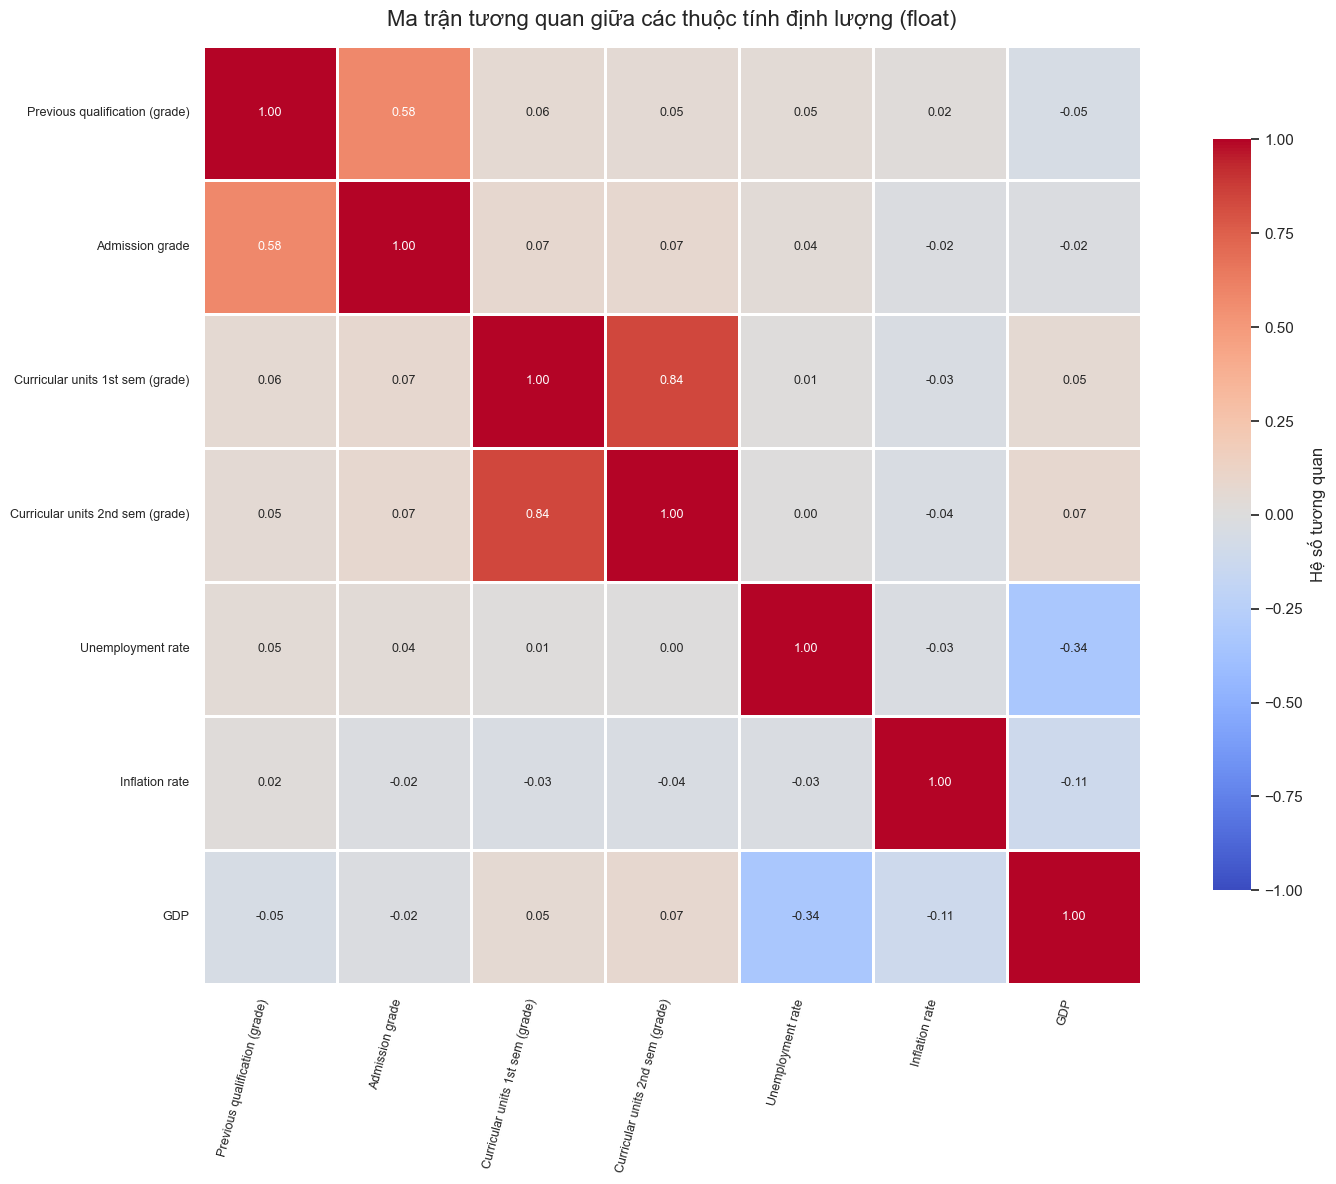

In [14]:
# Ma trận tương quan các thuộc tính định lượng (float)
import seaborn as sns
plt.figure(figsize=(16, 12))
sns.set_theme(style="white")

# Lọc các cột kiểu float (đây chính là nhóm biến giống trong ảnh)
df_float = X.select_dtypes(include=['float'])
corr = df_float.corr()

# Vẽ heatmap
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    linewidths=1.0,
    square=True,
    annot_kws={"size": 9},
    cbar_kws={"shrink": 0.8, "label": "Hệ số tương quan"}
)

plt.title("Ma trận tương quan giữa các thuộc tính định lượng (float)", fontsize=16, pad=14)
plt.xticks(rotation=75, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


## 4) Logistic Regression (thuần NumPy) + Gradient Descent  

Mình tự cài các hàm cần thiết: `sigmoid`, `loss (BCE)`, `predict_proba`, `predict_label` và vòng lặp GD để cập nhật trọng số.


In [5]:
# Hàm sigmoid và BCE ổn định số học
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_loss_logits(z, y):
    # Dùng công thức ổn định số học cho BCE theo logits:
    # BCE = mean( max(z,0) - y*z + log1p(exp(-abs(z))) )
    return np.mean(np.maximum(z, 0) - y*z + np.log1p(np.exp(-np.abs(z))))

def predict_proba(W, X):
    return sigmoid(X @ W)

def predict_label(W, X, thr=0.5):
    return (predict_proba(W, X) >= thr).astype(int)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# Khởi tạo tham số và siêu tham số
n, d = Xtr.shape
W = np.zeros((d,), dtype=float)
lr = 0.1
epochs = 500
losses = []

# Vòng lặp huấn luyện bằng Gradient Descent
for ep in range(epochs):
    z = Xtr @ W
    p = sigmoid(z)
    loss = bce_loss_logits(z, ytr)
    losses.append(loss)

    # gradient của BCE w.r.t W với outputs sigmoid
    grad = (Xtr.T @ (p - ytr)) / n
    W -= lr * grad

    # In theo mốc để theo dõi tiến độ
    if (ep + 1) % 50 == 0:
        print(f"Epoch {ep+1}/{epochs} | loss={loss:.6f}")


Epoch 50/500 | loss=0.419832
Epoch 100/500 | loss=0.389048
Epoch 150/500 | loss=0.375606
Epoch 200/500 | loss=0.367865
Epoch 250/500 | loss=0.362778
Epoch 300/500 | loss=0.359152
Epoch 350/500 | loss=0.356420
Epoch 400/500 | loss=0.354274
Epoch 450/500 | loss=0.352533
Epoch 500/500 | loss=0.351087


## 5) Đánh giá mô hình (train/test)  

Mình tính các chỉ số cơ bản: **accuracy**, **precision/recall/F1**, **confusion matrix** và **AUC** (tự cài).


In [6]:
def confusion_matrix_np(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp],[fn, tp]], dtype=int)

def precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)
    return prec, rec, f1

def roc_auc_score_numpy(y_true, y_score):
    # AUC theo Mann–Whitney U (cách đơn giản)
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    pos = y_score[y_true == 1]
    neg = y_score[y_true == 0]
    scores = np.concatenate([pos, neg])
    order = np.argsort(scores, kind='mergesort')

    # Cấp rank (sơ bộ); để đơn giản không xử lý tie-averaging chi tiết
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(scores) + 1)

    R_pos = ranks[:len(pos)].sum()
    n_pos = len(pos)
    n_neg = len(neg)
    U = R_pos - n_pos * (n_pos + 1) / 2.0
    auc = U / (n_pos * n_neg + 1e-12)
    return float(auc)

# Dự báo
yhat_tr = predict_label(W, Xtr)
yhat_te = predict_label(W, Xte)
p_te = predict_proba(W, Xte)

print("Train Accuracy:", accuracy(ytr, yhat_tr))
print("Test  Accuracy:", accuracy(yte, yhat_te))

cm = confusion_matrix_np(yte, yhat_te)
print("Confusion Matrix (Test):\n", cm)

prec, rec, f1 = precision_recall_f1(yte, yhat_te)
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

auc = roc_auc_score_numpy(yte, p_te)
print(f"ROC-AUC: {auc:.4f}")


Train Accuracy: 0.8411980785532637
Test  Accuracy: 0.8621468926553673
Confusion Matrix (Test):
 [[375  74]
 [ 48 388]]
Precision: 0.8398 | Recall: 0.8899 | F1: 0.8641
ROC-AUC: 0.9304


## 6) Biểu đồ loss trong quá trình train  

Quan sát loss giúp mình kiểm tra **hội tụ** và điều chỉnh `lr/epochs` nếu cần.


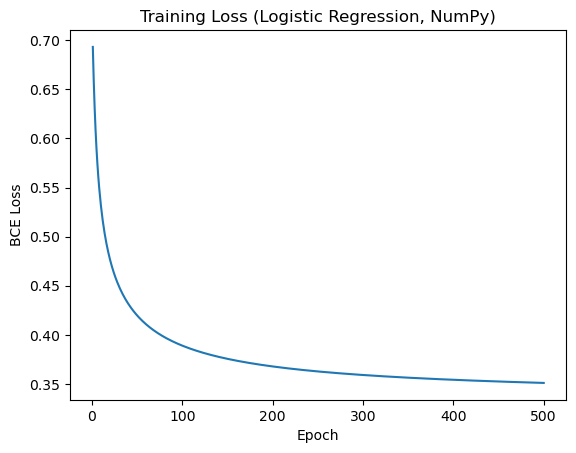

In [7]:
plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss (Logistic Regression, NumPy)")
safe_show()
